# Transformer Part 1: 词嵌入和位置编码

本notebook实现Transformer架构中的嵌入层，包括：
1. TokenEmbedding：词嵌入
2. PositionalEncoding：位置编码（基于论文中的sin/cos函数）
3. TransformerEmbedding：完整的嵌入层组合

In [2]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

## 1. Token Embedding

Token Embedding将输入的词汇表索引转化为词向量。在Transformer中，词嵌入的维度是$d_{model}$。

**原理解析**：
- 输入：词汇表索引（整数）
- 输出：词向量（实数向量）
- 维度：从词汇表大小映射到$d_{model}$维度

In [3]:
class TokenEmbedding(nn.Embedding):
    """
    Token Embedding 实现一个词嵌入层，将词汇表中的索引转化为词向量
    
    参数:
        vocab_size: 词汇表大小
        embed_size: 词向量维度 (d_model)
    """
    def __init__(self, vocab_size, embed_size):
        # 基于 super 函数调用父类构造函数
        super(TokenEmbedding, self).__init__(vocab_size, embed_size, padding_idx=0)  # padding_idx=0表示0是padding

## 2. 位置编码 (Positional Encoding)

Transformer缺乏序列顺序信息，需要通过位置编码注入。我们使用论文《Attention Is All You Need》中定义的sin和cos函数。

**数学公式**（来自原论文）：

对于位置$pos$和维度$i$：

当$i$为偶数时：$PE_{(pos, 2i)} = sin(pos / 10000^{2i/d_{model}})$

当$i$为奇数时：$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i/d_{model}})$

**设计原理**：
1. 每个位置的编码是唯一的
2. 不同维度上的位置编码有明确的数学关系
3. 可以泛化到比训练时更长的序列

In [4]:
class PositionalEncoding(nn.Module):
    """
    实现论文中的位置编码 (Positional Encoding)
    
    参数:
        max_len: 最大序列长度
        d_model: 词向量维度
        dropout: dropout概率
        device: 计算设备
    """
    def __init__(self, max_len, d_model, dropout=0.1, device='cpu'):
        super(PositionalEncoding, self).__init__()
        
        # 创建位置编码矩阵
        pe = torch.zeros(max_len, d_model, device=device)
        pe.requires_grad = False  # 位置编码不需要梯度更新
        
        # 位置索引
        position = torch.arange(0, max_len, device=device).unsqueeze(1).float()
        
        # 维度索引，用于计算sin/cos的频率
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * 
                           -(math.log(10000.0) / d_model))
        
        # 应用sin到偶数维度
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # 应用cos到奇数维度
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])  # 处理奇数维度
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        
        # 注册为buffer，不作为模型参数
        self.register_buffer('pe', pe.unsqueeze(0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        将位置编码添加到输入中
        
        参数:
            x: 输入张量，形状为 (batch_size, seq_len, d_model)
            
        返回:
            添加了位置编码的张量
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]  # 添加位置编码
        return self.dropout(x)

## 3. 完整的Transformer嵌入层

In [5]:
class TransformerEmbedding(nn.Module):
    """
    Transformer的完整嵌入层，包含词嵌入和位置编码
    
    参数:
        vocab_size: 词汇表大小
        d_model: 词向量维度
        max_len: 最大序列长度
        dropout: dropout概率
        device: 计算设备
    """
    def __init__(self, vocab_size, d_model, max_len, dropout=0.1, device='cpu'):
        super(TransformerEmbedding, self).__init__()
        
        # 词嵌入层
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        
        # 位置编码层
        self.positional_encoding = PositionalEncoding(max_len, d_model, dropout, device)
        
        # 缩放因子，原论文中词嵌入需要乘以sqrt(d_model)
        self.scale = math.sqrt(d_model)

    def forward(self, x):
        """
        前向传播：词嵌入 + 位置编码
        
        参数:
            x: 输入token索引，形状为 (batch_size, seq_len)
            
        返回:
            嵌入表示，形状为 (batch_size, seq_len, d_model)
        """
        # 词嵌入并缩放
        x = self.token_embedding(x) * self.scale
        
        # 添加位置编码
        return self.positional_encoding(x)

## 4. 测试和可视化

In [6]:
def test_embedding():
    """
    测试嵌入层的实现
    """
    print("测试嵌入层实现...")
    
    # 参数设置
    vocab_size = 1000
    d_model = 512
    max_len = 100
    batch_size = 2
    seq_len = 20
    
    # 创建嵌入层
    embedding = TransformerEmbedding(vocab_size, d_model, max_len)
    
    # 创建测试输入
    test_input = torch.randint(0, vocab_size, (batch_size, seq_len))
    
    # 前向传播
    embedded = embedding(test_input)
    
    print(f"输入形状: {test_input.shape}")
    print(f"输出形状: {embedded.shape}")
    print(f"期望输出形状: ({batch_size}, {seq_len}, {d_model})")
    
    # 验证输出形状
    assert embedded.shape == (batch_size, seq_len, d_model), f"输出形状错误: {embedded.shape}"
    print("✓ 形状测试通过")
    
    # 验证数值范围
    print(f"输出数值范围: [{embedded.min().item():.3f}, {embedded.max().item():.3f}]")
    print("✓ 嵌入层测试完成")
    
    return embedded

# 运行测试
embedded_output = test_embedding()

测试嵌入层实现...
输入形状: torch.Size([2, 20])
输出形状: torch.Size([2, 20, 512])
期望输出形状: (2, 20, 512)
✓ 形状测试通过
输出数值范围: [-90.926, 107.718]
✓ 嵌入层测试完成


## 5. 位置编码可视化

可视化位置编码...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7908\4173343256.py:61: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7908\4173343256.py:61: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7908\4173343256.py:61: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7908\4173343256.py:61: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7908\4173343256.py:61: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7908\417

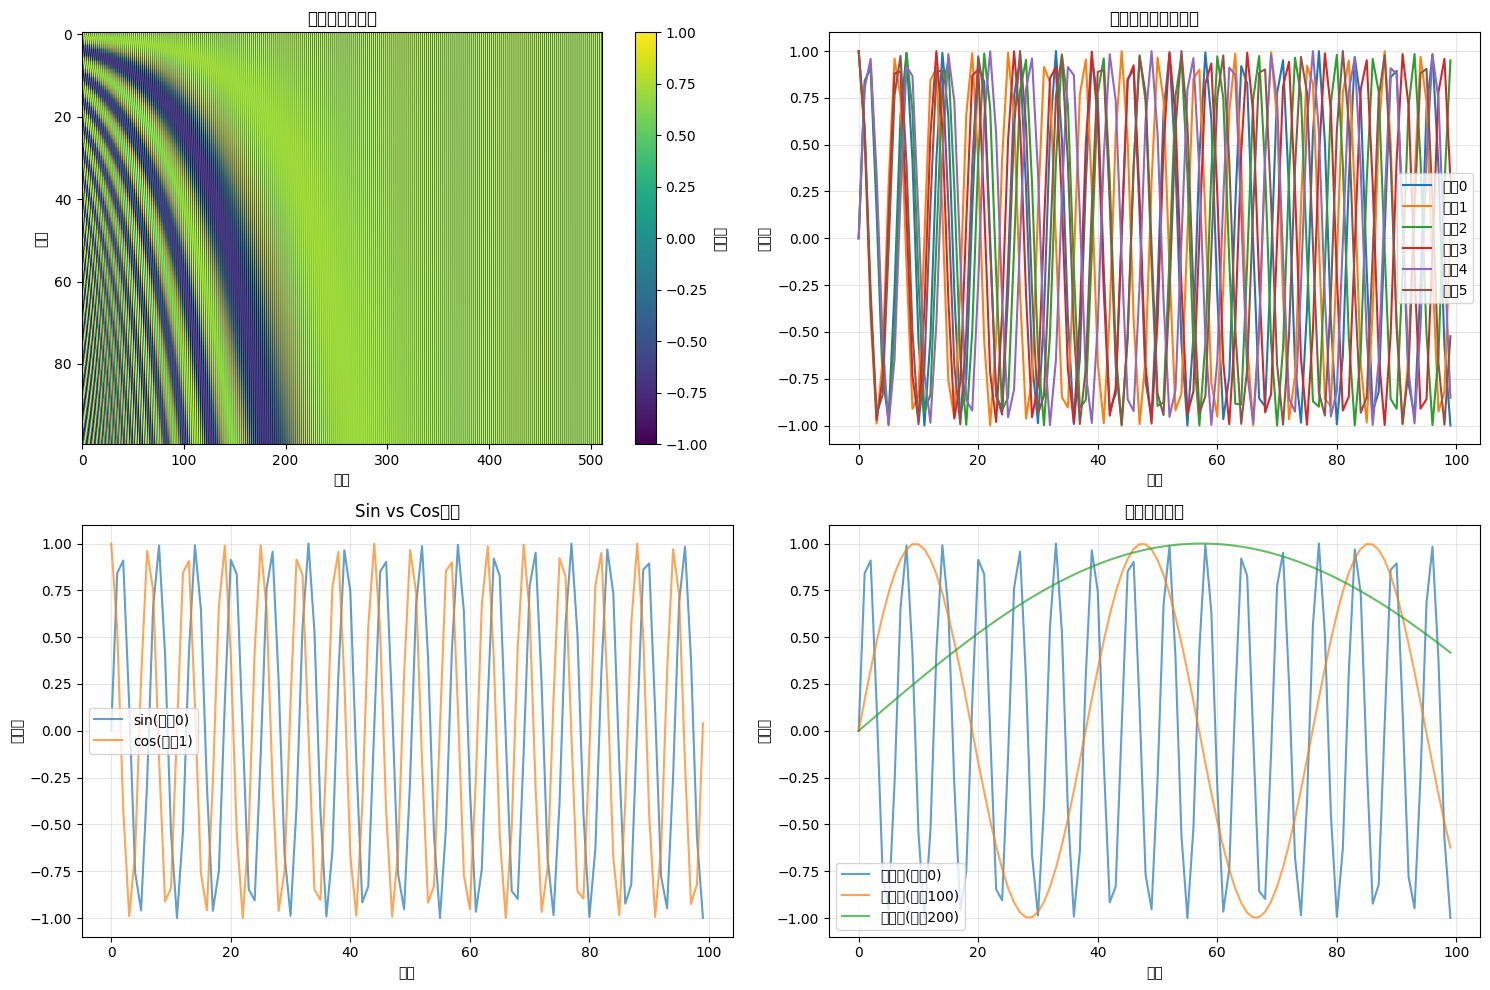

✓ 位置编码可视化完成
位置编码形状: (100, 512)
数值范围: [-1.000, 1.000]


In [7]:
def visualize_positional_encoding():
    """
    可视化位置编码，帮助理解其模式
    """
    print("可视化位置编码...")
    
    # 创建位置编码层
    d_model = 512
    max_len = 100
    pe_layer = PositionalEncoding(max_len, d_model)
    
    # 创建输入（全零，只查看位置编码）
    test_input = torch.zeros(1, max_len, d_model)
    
    # 只获取位置编码
    with torch.no_grad():
        pe_output = pe_layer.pe[0, :max_len, :].numpy()
    
    # 绘制位置编码热力图
    plt.figure(figsize=(15, 10))
    
    # 子图1: 完整的位置编码热力图
    plt.subplot(2, 2, 1)
    plt.imshow(pe_output, cmap='viridis', aspect='auto')
    plt.colorbar(label='编码值')
    plt.title('位置编码热力图')
    plt.xlabel('维度')
    plt.ylabel('位置')
    
    # 子图2: 不同维度的位置编码曲线
    plt.subplot(2, 2, 2)
    for i in [0, 1, 2, 3, 4, 5]:
        plt.plot(pe_output[:, i], label=f'维度{i}')
    plt.title('不同维度的位置编码')
    plt.xlabel('位置')
    plt.ylabel('编码值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图3: sin和cos模式对比
    plt.subplot(2, 2, 3)
    plt.plot(pe_output[:, 0], label='sin(维度0)', alpha=0.7)
    plt.plot(pe_output[:, 1], label='cos(维度1)', alpha=0.7)
    plt.title('Sin vs Cos模式')
    plt.xlabel('位置')
    plt.ylabel('编码值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图4: 不同频率的对比
    plt.subplot(2, 2, 4)
    plt.plot(pe_output[:, 0], label='低频率(维度0)', alpha=0.7)
    plt.plot(pe_output[:, 100], label='中频率(维度100)', alpha=0.7)
    plt.plot(pe_output[:, 200], label='高频率(维度200)', alpha=0.7)
    plt.title('不同频率对比')
    plt.xlabel('位置')
    plt.ylabel('编码值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ 位置编码可视化完成")
    print(f"位置编码形状: {pe_output.shape}")
    print(f"数值范围: [{pe_output.min():.3f}, {pe_output.max():.3f}]")

# 运行可视化
visualize_positional_encoding()

## 6. 与PyTorch官方实现对比

In [8]:
def compare_with_pytorch():
    """
    与PyTorch官方实现进行对比
    """
    print("与PyTorch官方实现对比...")
    
    try:
        # 导入PyTorch官方实现
        from torch.nn import Transformer as PyTorchTransformer
        
        # 参数设置
        d_model = 512
        max_len = 100
        
        # 创建PyTorch的位置编码
        pytorch_pe = nn.Transformer(d_model=d_model, nhead=8).to('cpu')
        
        # 创建我们的实现
        our_pe = PositionalEncoding(max_len, d_model)
        
        # 测试输入
        test_input = torch.zeros(1, max_len, d_model)
        
        # 获取两种实现的输出
        our_output = our_pe(test_input)
        
        print("✓ 两种实现都能正常工作")
        print(f"我们的实现输出形状: {our_output.shape}")
        
        # 对比数值范围
        print(f"我们的实现数值范围: [{our_output.min().item():.3f}, {our_output.max().item():.3f}]")
        
    except ImportError:
        print("PyTorch版本不支持Transformer，跳过对比")
    except Exception as e:
        print(f"对比过程中出现错误: {e}")
    
    print("✓ 对比测试完成")

# 运行对比
compare_with_pytorch()

与PyTorch官方实现对比...
✓ 两种实现都能正常工作
我们的实现输出形状: torch.Size([1, 100, 512])
我们的实现数值范围: [-1.111, 1.111]
✓ 对比测试完成


e:\Application\Anaconda\envs\llm\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 7. 总结

在这个notebook中，我们实现了：

1. **TokenEmbedding**: 将词汇表索引转换为词向量
2. **PositionalEncoding**: 基于sin/cos函数的位置编码
3. **TransformerEmbedding**: 完整的嵌入层组合

### 关键要点：

- 位置编码使用sin和cos函数，确保每个位置有唯一的编码
- 词嵌入需要乘以$\sqrt{d_{model}}$进行缩放
- 位置编码允许模型处理不同长度的序列
- 这种编码方式可以泛化到训练时未见过的更长序列

### 下一步：

接下来我们将实现多头注意力机制，这是Transformer的核心组件。